# DEEP DREAM ALGORTITHM IMPLEMENTATION

- Implement deep dream algorithm using your own image.

### Setting up Libraries, Loading the pretrained model

In [ ]:
!pip install tensorflow pillow matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Load the pre-trained InceptionV3 model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Layers to use for Deep Dream
dream_layers = ['mixed3', 'mixed5']

# Create a model to extract activations from selected layers
outputs = [base_model.get_layer(layer).output for layer in dream_layers]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Function to preprocess input image

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).resize((800, 600))  # Resize to a manageable size
    img = np.array(img).astype(np.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return tf.convert_to_tensor(img)

### Function to deprocess image (convert back to displayable format)

In [ ]:
def deprocess_image(img_tensor):
    img = img_tensor.numpy()
    img = img - img.min()
    img = img / img.max()
    img = (img * 255).astype(np.uint8)
    return img

### Define Deep Dream loss function

In [ ]:
def deep_dream_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    loss = tf.reduce_sum([tf.reduce_mean(act) for act in layer_activations])
    return loss

### Compile the Deep Dream step into a TensorFlow graph for optimization

In [ ]:
@tf.function
def deep_dream_step(img, model, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = deep_dream_loss(img, model)  # Calculate loss
    gradients = tape.gradient(loss, img)  # Compute gradients
    gradients /= tf.math.reduce_std(gradients) + 1e-8  # Normalize gradients
    img = img + gradients * learning_rate  # Apply gradient ascent
    img = tf.clip_by_value(img, -1, 1)  # Clip image values
    return img

### Main function to run Deep Dream

In [ ]:
def run_deep_dream(image_path, steps=100, learning_rate=0.01, output_path='deep_dream_output.jpg'):
    print("Preprocessing the image...")
    img = preprocess_image(image_path)

    # Subplot setup for visualization
    num_intervals = steps // 20 + 1
    plt.figure(figsize=(15, num_intervals * 3))
    subplot_idx = 1

    print("Starting Deep Dream...")
    for step in range(steps):
        img = deep_dream_step(img, dream_model, learning_rate)  # Perform gradient ascent

        # Visualize every 20 steps
        if step % 20 == 0 or step == steps - 1:
            print(f"Step {step}/{steps}: Visualizing progress...")
            plt.subplot(num_intervals, 2, subplot_idx)
            plt.imshow(deprocess_image(img))
            plt.axis('off')
            plt.title(f"Step {step}")
            subplot_idx += 1

    print("Deep Dream completed. Saving the output...")
    result_img = deprocess_image(img)
    Image.fromarray(result_img).save(output_path)  # Save the final image

    # Show all the subplots
    plt.tight_layout()
    plt.show()
    return result_img

### Demonstrating the pipeline

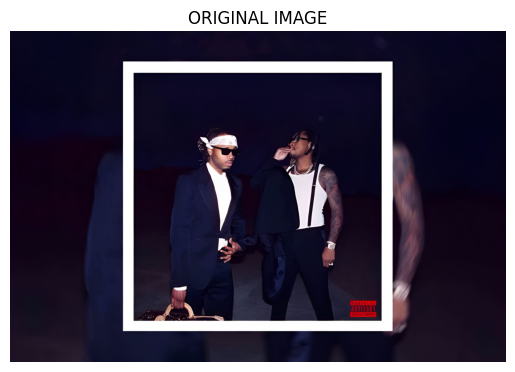

In [ ]:
if __name__ == "__main__":
    image_path = '/content/metro_future.jpeg'
    output_path = '/content/deep_dream_output.jpg'

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title("ORIGINAL IMAGE")
    plt.show()

Preprocessing the image...
Starting Deep Dream...
Step 0/100: Visualizing progress...
Step 20/100: Visualizing progress...
Step 40/100: Visualizing progress...
Step 60/100: Visualizing progress...
Step 80/100: Visualizing progress...
Step 99/100: Visualizing progress...
Deep Dream completed. Saving the output...


<Figure size 800x600 with 0 Axes>

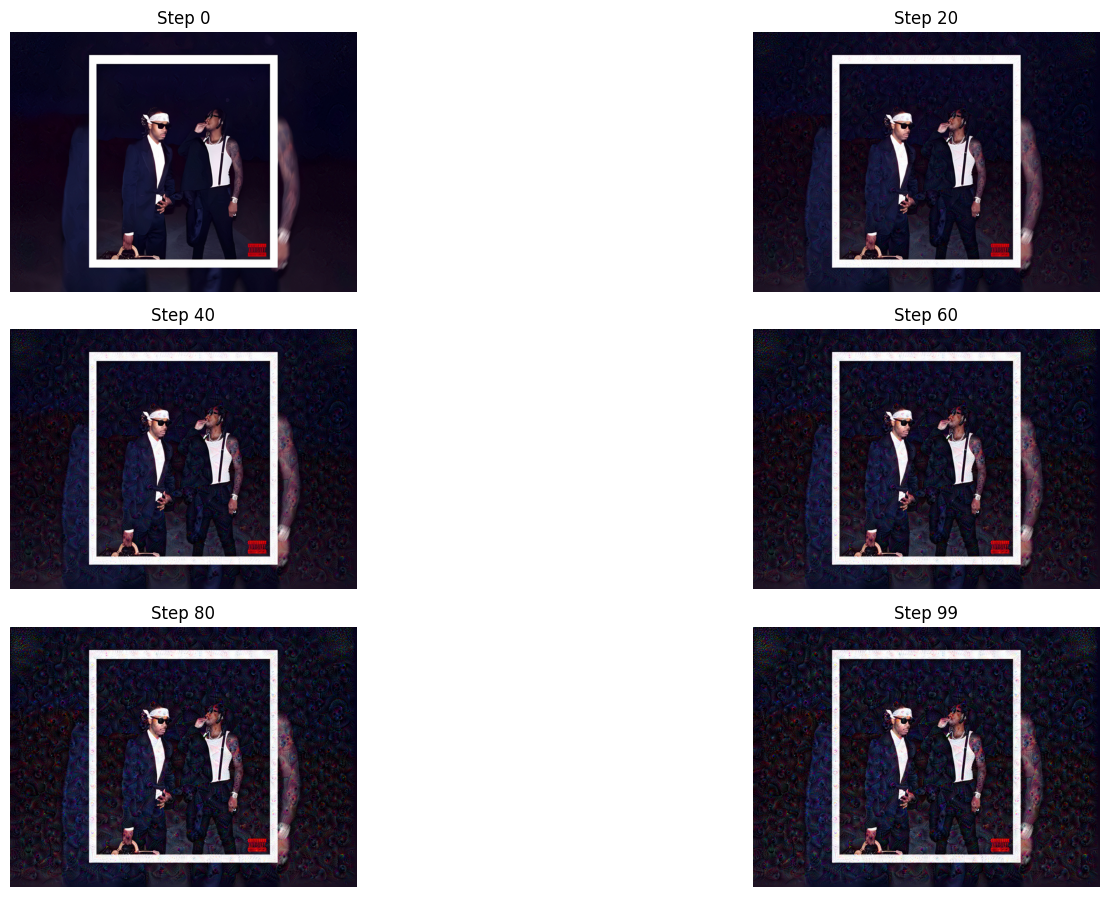

In [ ]:
plt.figure(figsize=(8, 6))
deep_dream_image = run_deep_dream(image_path, steps=100, learning_rate=0.01, output_path=output_path)

<hr>